# masking value별(전체 sst의 평균, -99, -50, 50, 99) 모델 성능 비교 및 최종 모델 선정
* 최종 모델은 masking value가 전체 sst의 평균이고, epochs는 20인 모델로 선정함

## 라이브러리 불러오기

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv3D, ConvLSTM2D, BatchNormalization
from keras import callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import netCDF4 as nc
import pandas as pd

## 데이터 불러오기

데이터 path 설정

In [2]:
## !!! 경로 수정 필요
official_data_path = './official_data/'
our_data_path = './val_test_data/'

sst 데이터 xarray로 불러오기

In [3]:
# xr_raw_sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc', decode_times=False)
xr_raw_sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc')

# 인도양 부근(lon: 40~120, lat: -19.5~19.5)을 crop한 데이터
xr_raw_sst_india = xr.open_dataset(our_data_path+'sst_.nc')

d:\anaconda3\envs\final_sealab\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


xarray를 numpy로 변경

In [4]:
np_raw_sst = xr_raw_sst['sst'].data
print(np_raw_sst.shape)

# 인도양 부근(lon: 40~120, lat: -19.5~19.5)을 crop한 데이터
np_raw_sst_india = xr_raw_sst_india['sst'].data
print(np_raw_sst_india.shape)

(499, 180, 360)
(499, 40, 81)


모델 평가를 위해 저장해 놓은 validation set 불러오기

In [5]:
xy_val = np.load(our_data_path + 'xy_val.npz')
x_val = xy_val['x_val']
y_val = xy_val['y_val']

# 인도양 부근(lon: 40~120, lat: -19.5~19.5)을 crop한 데이터
xy_val_india = np.load(our_data_path + 'india_xy_val.npz')
x_val_india = xy_val_india['x_val']
y_val_india = xy_val_india['y_val']

## 모델 불러와 iod 예측

모델 저장 경로 및 불러올 모델명 선언

In [9]:
model_path = './models/'
n_maskmean = 'maskmean_epochs20.h5'
n_maskm99 = 'maskm99_epochs20.h5'
n_maskm50 = 'maskm50_epochs20.h5'
n_maskp50 = 'maskp50_epochs20.h5'
n_maskp99 = 'maskp99_epochs20.h5'
n_maskmean_e30 = 'maskmean_epochs30.h5'
n_maskmean_india = 'maskmean_epochs20_india.h5'

모델 불러오기

In [13]:
maskmean = load_model(model_path + n_maskmean, compile=False)
maskm99 = load_model(model_path + n_maskm99, compile=False)
maskm50 = load_model(model_path + n_maskm50, compile=False)
maskp50 = load_model(model_path + n_maskp50, compile=False)
maskp99 = load_model(model_path + n_maskp99, compile=False)
maskmean30 = load_model(model_path + n_maskmean_e30, compile=False)
maskmean_india = load_model(model_path + n_maskmean_india, compile=False)

### 인도양 부근을 crop한 데이터로 학습한 모델 성능 검증

In [16]:
# 데이터를 xarray로 만드는 함수 선언
def to_xr_india(data):
  return xr.DataArray(
    data=data,
    dims = ['time', 'lat', 'lon'],
    coords = dict(
        lon = ('lon', xr_raw_sst_india.lon.data),
        lat = ('lat', xr_raw_sst_india.lat.data),
        time = ('time', pd.date_range('2023-08-01', periods=12, freq='MS'))
        )
    )

# sst 평균으로 iod 구하는 함수 선언
def wtio_setio_iod(xr_sst):
  wtio_sst = xr_sst.sel(lat=slice(-10, 10), lon=slice(50, 70)).data
  setio_sst = xr_sst.sel(lat=slice(-10, 0), lon=slice(90, 110)).data

  wtio_sst_mean = [np.nanmean(wtio_sst[i]) for i in range(len(wtio_sst))]
  setio_sst_mean = [np.nanmean(setio_sst[i]) for i in range(len(setio_sst))]

  iod = [wtio_sst_mean[i] - setio_sst_mean[i] for i in range(len(wtio_sst))]

  return wtio_sst, setio_sst, iod

In [17]:
# 마스킹 해제 위해 마스킹된 인덱스값 가져오기
nc_raw_sst_india = nc.Dataset(our_data_path + 'sst_.nc')
masked_india = nc_raw_sst_india['sst'][:].mask
masked_india = masked_india[-12:]

# 검증을 위한 실제 iod값 불러오기
# xr_iod = xr.open_dataset(official_data_path+'iod.nc', decode_times=False)
xr_iod = xr.open_dataset(official_data_path+'iod.nc')
true_iod = xr_iod.iod.data[-12:].reshape((12))

# 주어진 sst를 이용해 직접 해당 기간의 iod값 구하기
semi_wtio_sst, semi_setio_sst, semi_iod = wtio_setio_iod(xr_raw_sst.sst[-12:])

# 모델 성능을 확인하기 위한 함수 선언
def model_predict_plot_india(model, data):
    # 불러온 모델로 예측 실행
    pred = model.predict(data)
    pred = pred[:, 3, ...].reshape((12, *np_raw_sst_india.shape[1:]))

    # 마스킹 했던 부분을 다시 nan으로 변환
    pred[masked_india] = np.nan

    # 예측 데이터를 xarray 형태로 변환
    xr_pred = to_xr_india(pred)

    # 예측 데이터로 iod 구하기
    pred_wtio_sst, pred_setio_sst, pred_iod =  wtio_setio_iod(xr_pred)

    # 4개 평균 낸 데이터 시각화
    val_month_list = ['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01']

    plt.figure(figsize=(15,8))
    plt.plot(val_month_list, true_iod, label='true', color='red')
    plt.plot(val_month_list, semi_iod, label='semi', color='blue')
    plt.plot(val_month_list, pred_iod, label='pred', color='green')
    plt.title('IOD comparison')
    plt.xlabel('time')
    plt.ylabel('IOD')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    print('='*90)

    # MAE, MSE, RMSE 확인
    print(f'실제 IOD와 직접 계산한 IOD 간의 MAE: {mean_absolute_error(true_iod, semi_iod)}')
    print(f'실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: {mean_absolute_error(true_iod, pred_iod)}')

    print('='*90)

    print(f'실제 IOD와 직접 계산한 IOD 간의 RMSE: {mean_squared_error(true_iod, semi_iod, squared=False)}')
    print(f'실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: {mean_squared_error(true_iod, pred_iod, squared=False)}')

1/1 [==============================] - 8s 8s/step


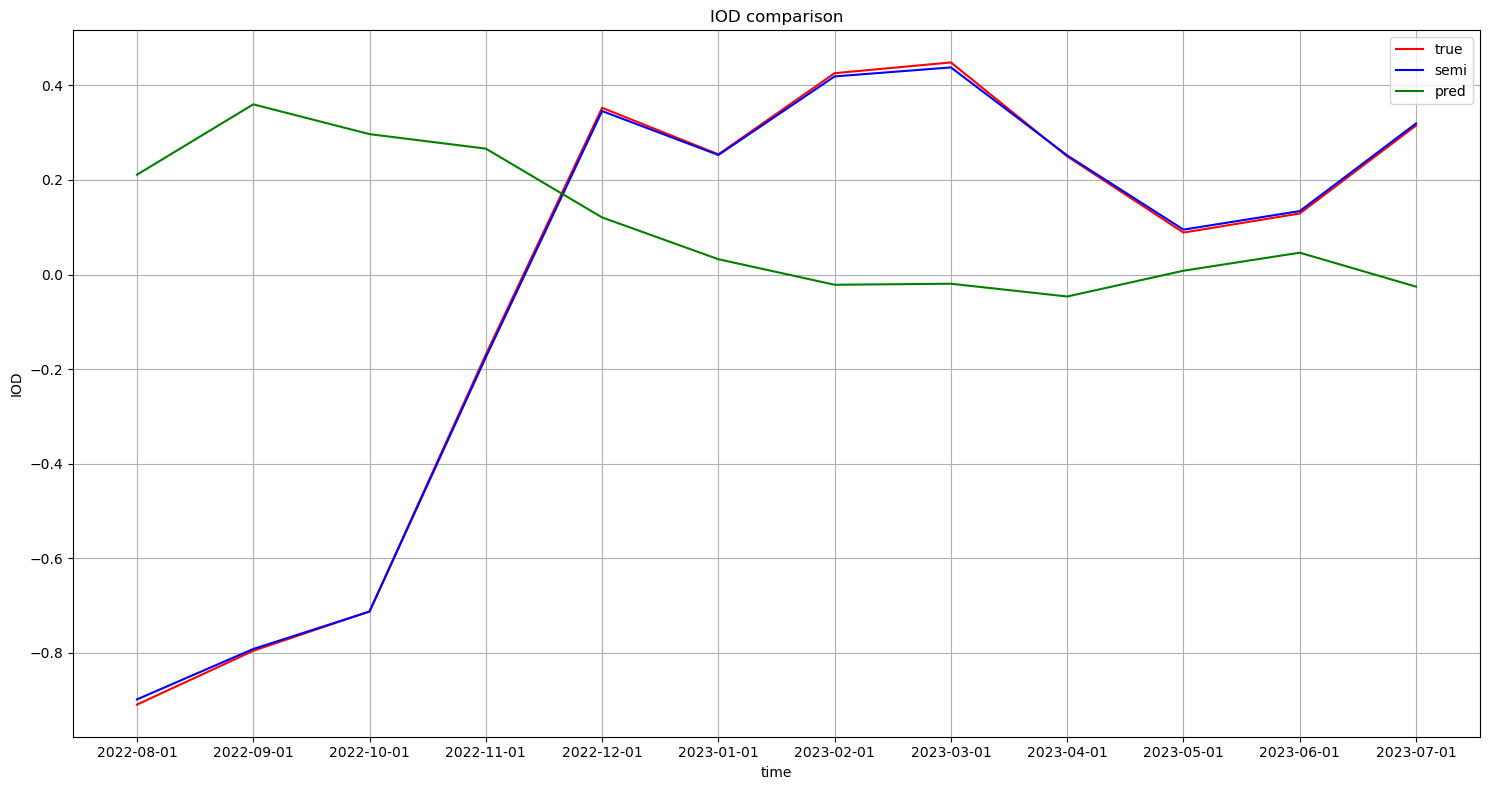

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.49073436856269836
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.6148127913475037


In [18]:
 model_predict_plot_india(maskmean_india, x_val_india)

### 전체 데이터로 학습한 모델 성능 검증

In [19]:
# 데이터를 xarray로 만드는 함수 선언
def to_xr(data):
  return xr.DataArray(
    data=data,
    dims = ['time', 'lat', 'lon'],
    coords = dict(
        lon = ('lon', xr_raw_sst.lon.data),
        lat = ('lat', xr_raw_sst.lat.data),
        time = ('time', pd.date_range('2023-08-01', periods=12, freq='MS'))
        )
    )

In [20]:
# 마스킹 해제 위해 마스킹된 인덱스값 가져오기
nc_raw_sst = nc.Dataset(official_data_path+'sst.anom.mon.mean.nc')
masked = nc_raw_sst['sst'][:].mask
masked = masked[-12:]

# 모델 성능을 확인하기 위한 함수 선언
def model_predict_plot(model, data):
    # 불러온 모델로 예측 실행
    pred = model.predict(data)
    pred = pred[:, 3, ...].reshape((12, *np_raw_sst.shape[1:]))

    # 마스킹 했던 부분을 다시 nan으로 변환
    pred[masked] = np.nan

    # 예측 데이터를 xarray 형태로 변환
    xr_pred = to_xr(pred)

    # 예측 데이터로 iod 구하기
    pred_wtio_sst, pred_setio_sst, pred_iod =  wtio_setio_iod(xr_pred)

    # 데이터 시각화
    val_month_list = ['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01']

    plt.figure(figsize=(15,8))
    plt.plot(val_month_list, true_iod, label='true', color='red')
    plt.plot(val_month_list, semi_iod, label='semi', color='blue')
    plt.plot(val_month_list, pred_iod, label='pred', color='green')
    plt.title('IOD comparison')
    plt.xlabel('time')
    plt.ylabel('IOD')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    print('='*90)

    # MAE, RMSE 확인
    print(f'실제 IOD와 직접 계산한 IOD 간의 MAE: {mean_absolute_error(true_iod, semi_iod)}')
    print(f'실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: {mean_absolute_error(true_iod, pred_iod)}')

    print('='*90)

    print(f'실제 IOD와 직접 계산한 IOD 간의 RMSE: {mean_squared_error(true_iod, semi_iod, squared=False)}')
    print(f'실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: {mean_squared_error(true_iod, pred_iod, squared=False)}')

#### masking value가 SST 평균인 모델

1/1 [==============================] - 14s 14s/step


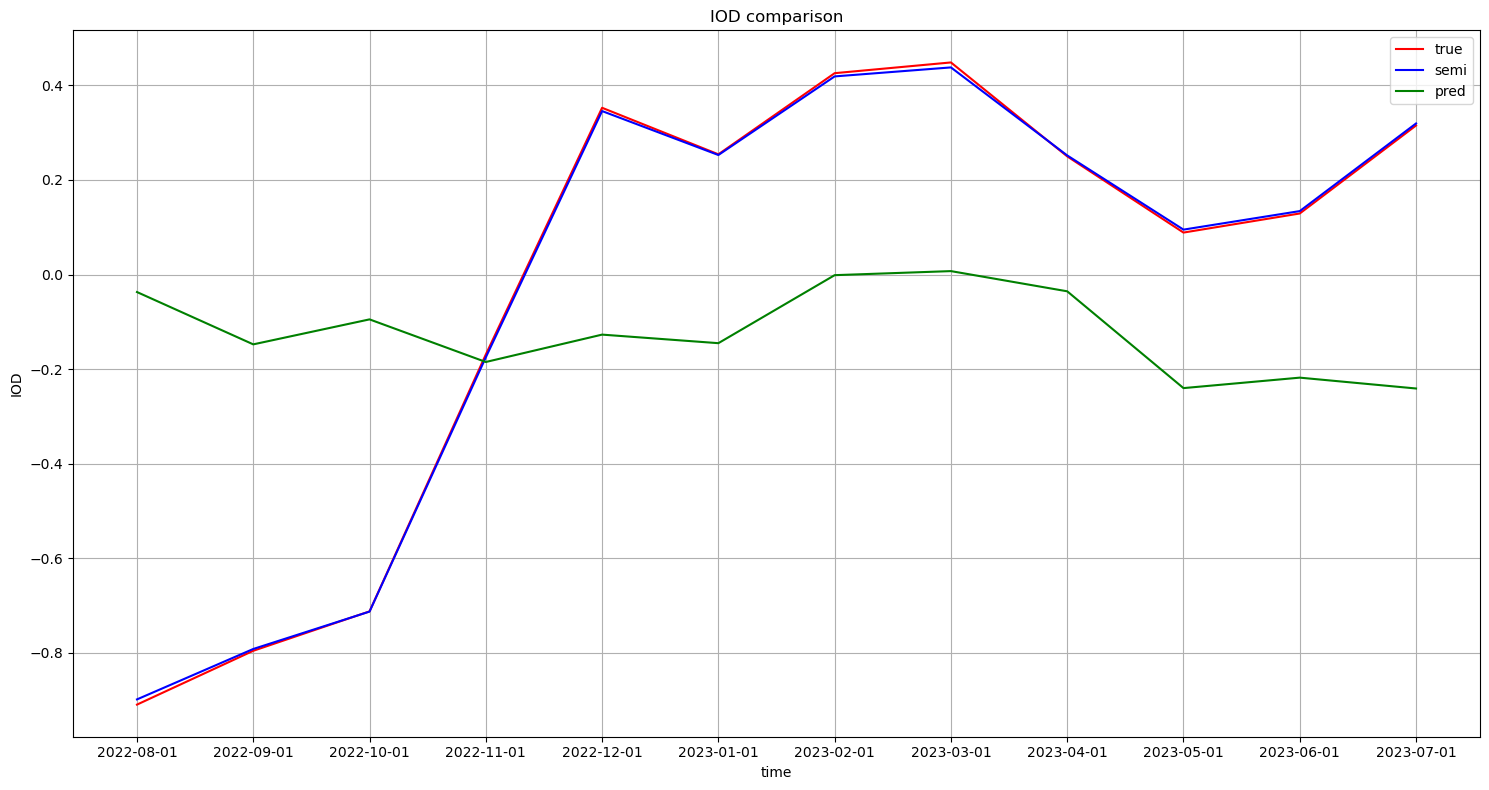

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.4514283835887909
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.4955652952194214


In [21]:
 model_predict_plot(maskmean, x_val)

#### masking value가 -99인 모델

1/1 [==============================] - 11s 11s/step


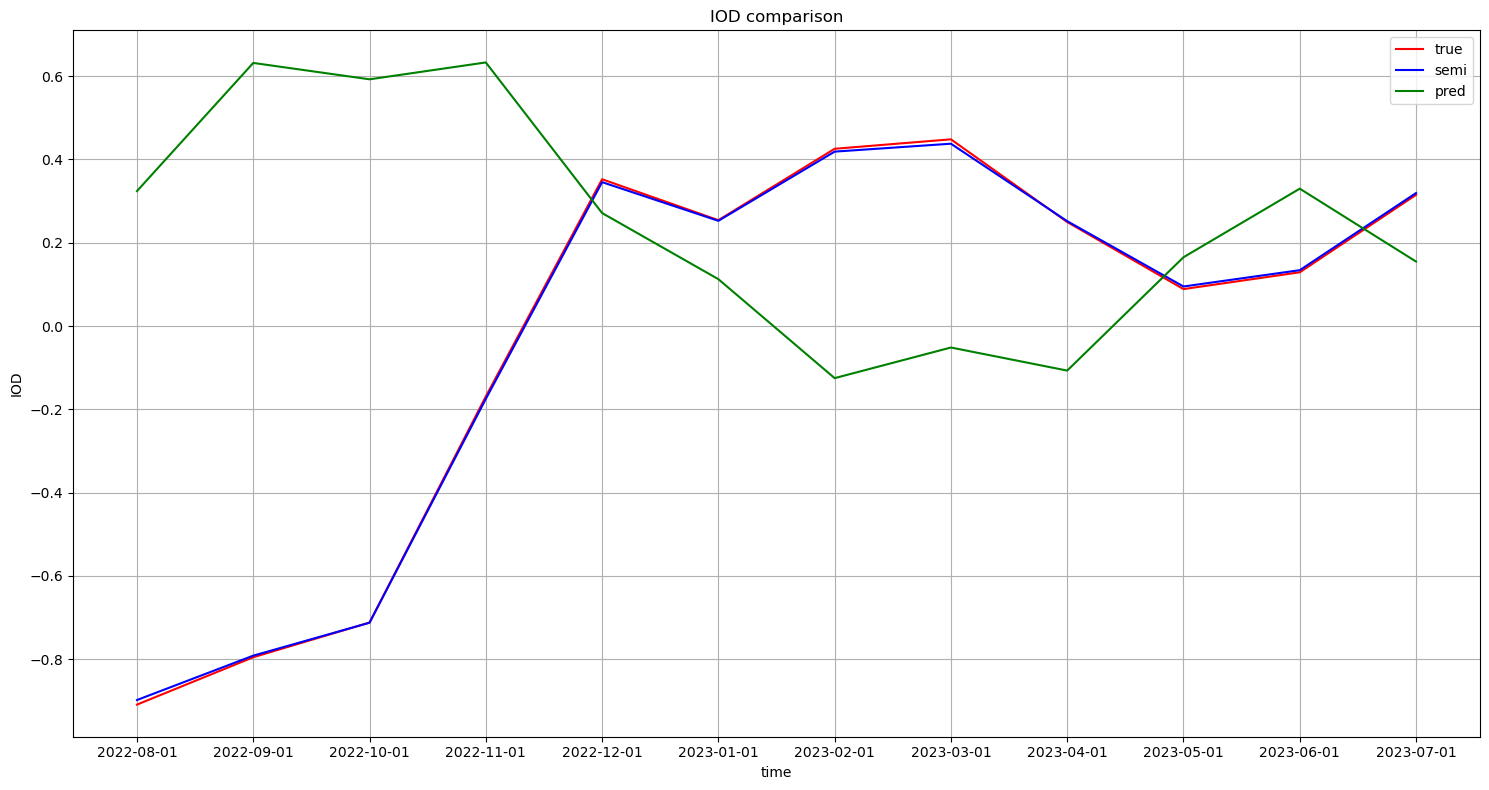

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.5696021914482117
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.7462562918663025


In [22]:
 model_predict_plot(maskm99, x_val)

#### masking value가 -50인 모델

1/1 [==============================] - 10s 10s/step


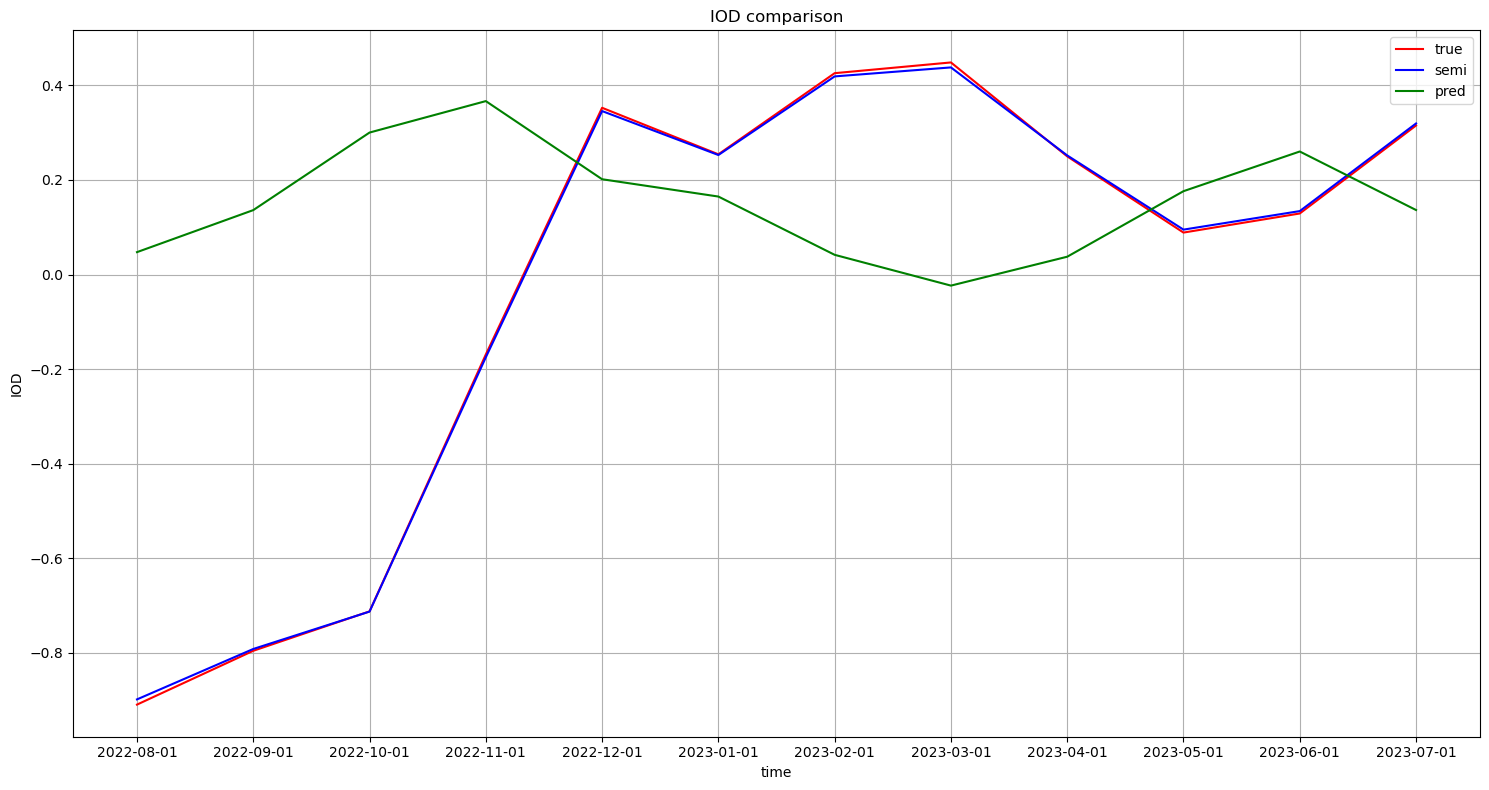

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.4284704029560089
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.5475092530250549


In [23]:
model_predict_plot(maskm50, x_val)

#### masking value가 50인 모델

1/1 [==============================] - 11s 11s/step


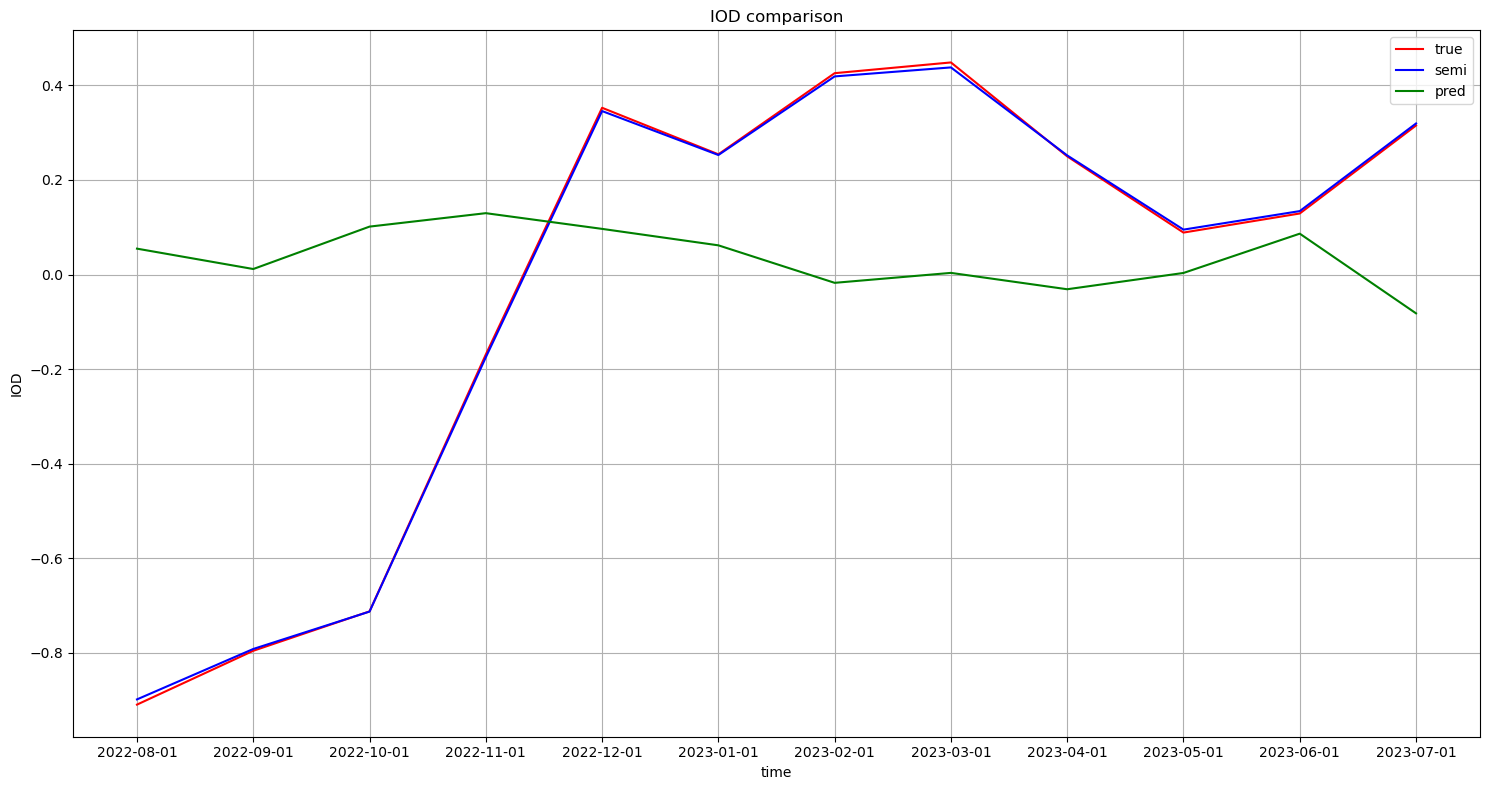

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.41882023215293884
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.5061454772949219


In [24]:
model_predict_plot(maskp50, x_val)

#### masking value가 99인 모델

1/1 [==============================] - 12s 12s/step


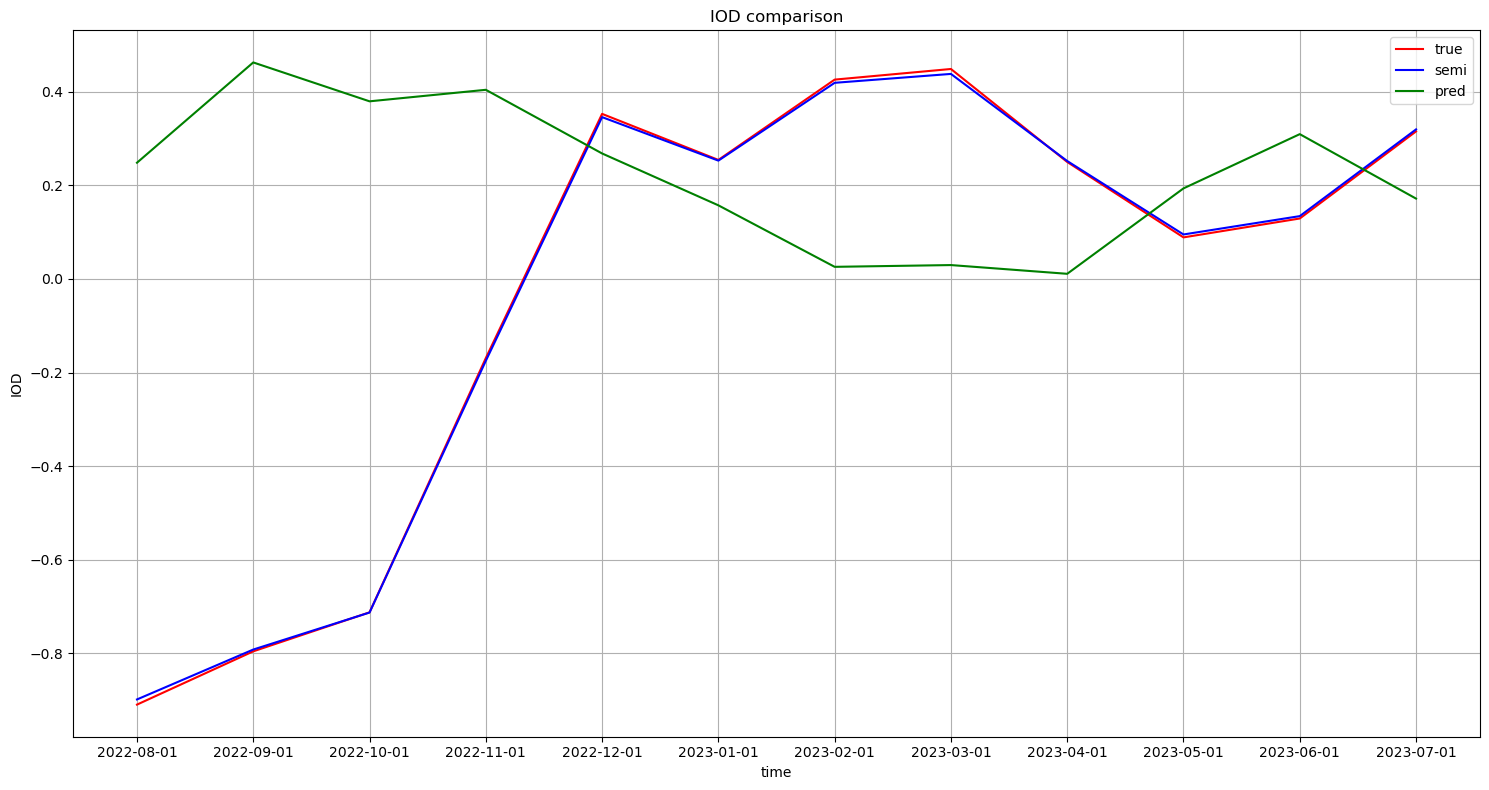

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.4789161682128906
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.6399259567260742


In [25]:
model_predict_plot(maskp99, x_val)

#### masking value가 mean이고 epochs가 30인 모델

1/1 [==============================] - 11s 11s/step


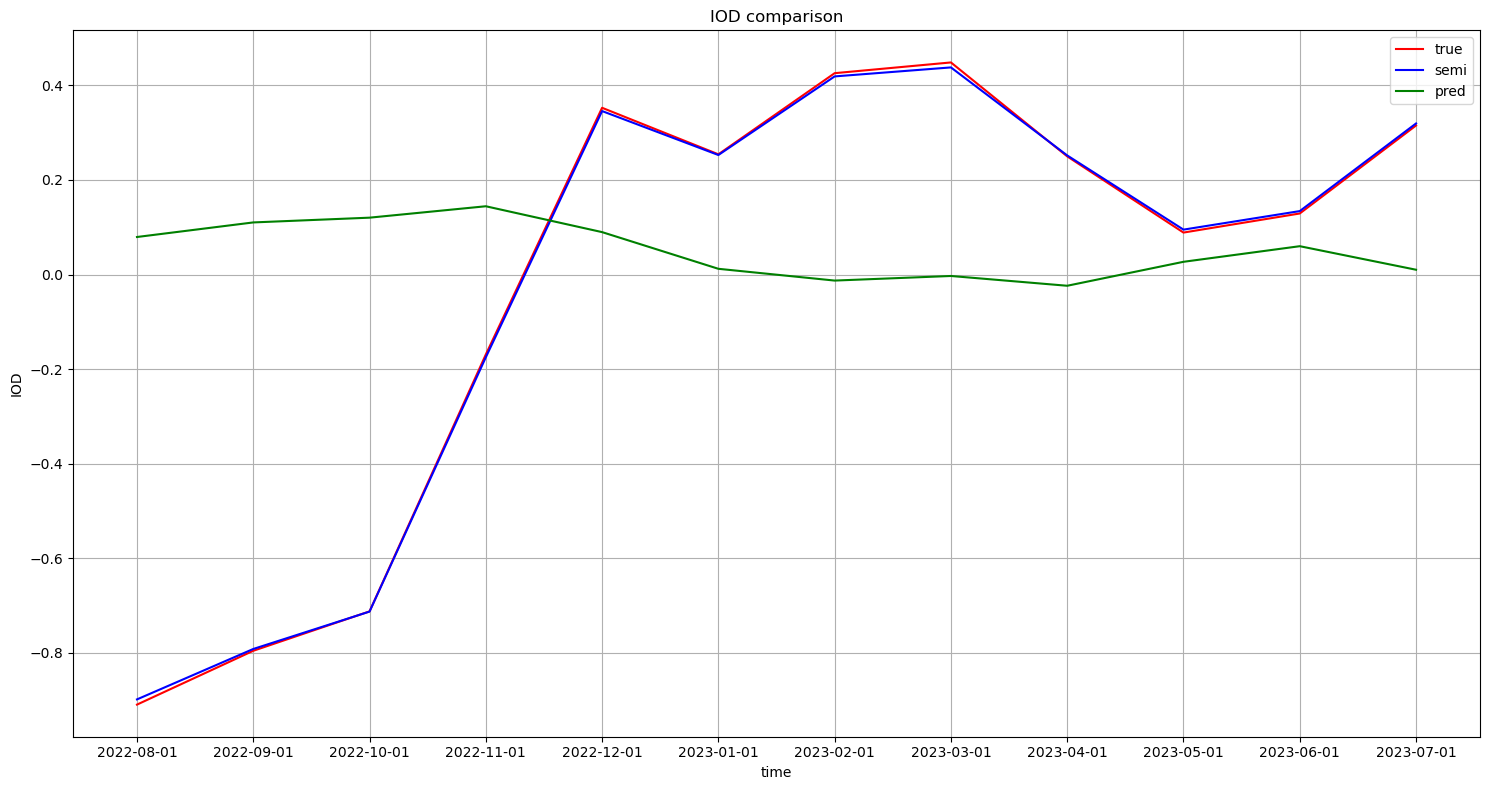

실제 IOD와 직접 계산한 IOD 간의 MAE: 0.0053767128847539425
실제 IOD와 예측 데이터로 얻은 IOD 간의 MAE: 0.4286707937717438
실제 IOD와 직접 계산한 IOD 간의 RMSE: 0.006228892598301172
실제 IOD와 예측 데이터로 얻은 IOD 간의 RMSE: 0.523486316204071


In [26]:
model_predict_plot(maskmean30, x_val)

# 결론

* 실제 IOD의 추세와 비슷한 형태로 예측한 모델로 최종 모델을 선정
* masking value가 전체 SST의 평균이고, 20 epochs를 학습시킨 모델